# Table of contents

1. [Get data](#Get-data)
2. [Check data](#Check-data)
3. [Load data](#Load-data)
4. [Plot](#Plot)

# Import os library to run get data part

In [1]:
import os

# Get data
<div class="alert alert-block alert-danger"> <b> I created some scripts to get data from the server and parse them correctly. They will be downloaded into your machine, so you don't need to run these chunk again in the future.</b> This is just to make sure that we are analyzing on the same data and tutor can check them easily 

Check current working directory, make sure this directory is where you want to work in. I will create a subdirectory called "data" and download all csv files in there

In [2]:
os.getcwd()

'C:\\Users\\VIET\\Desktop\\Python\\NPF-smearII'

Download all data and put in a subdirectory called 'data'. A success run will return value 0

In [3]:
os.system('python download_data.py') # exploit multi-threading for IO

0

Combine all data in to a new csv file called fulldata.csv. A success run will return value 0

In [4]:
os.system('python parse_data.py') # exploit multi-processing CPU to parse each file on each CPU

0

******

<div class="alert alert-block alert-success"> <b>START FROM HERE IF YOU ALREADY HAVE THE DATA <b>

# Load libraries

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates
import seaborn as sns

# Load data

In [39]:
df_raw = pd.read_csv('fulldata.csv', parse_dates = ['Time'])
df_raw.columns = [x if x == "Time" else x[9:] for x in df_raw.columns] # Remove unnecessary part in column names

In [40]:
event = pd.read_csv('Event_classification_2004-2014.csv')
event['Time'] = pd.to_datetime(event.Date, format = "%d-%b-%Y")
event.drop('Date', axis = 1, inplace = True)

condense_raw = pd.read_csv('CS_2004_2014.csv')
condense_raw['Time'] = pd.to_datetime(condense_raw.times, format = "%d-%b-%Y %H:%M:%S")
condense_raw.drop('times', axis = 1, inplace = True)
condense_raw.rename(columns = {'Condensation_sink': 'CS_sink'}, inplace = True)

In [41]:
condense_raw

,CS_sink,Time
0,0.002163,2004-01-01 00:08:41
1,0.003151,2004-01-01 00:18:40
2,0.002770,2004-01-01 00:28:41
3,0.001783,2004-01-01 00:38:40
4,0.001543,2004-01-01 00:48:40
...,...,...
568294,0.002030,2014-12-31 23:10:01
568295,0.002027,2014-12-31 23:20:00
568296,0.001903,2014-12-31 23:30:01
568297,0.001925,2014-12-31 23:40:00


### Get 2008 & 2009

In [42]:
condense_raw = condense_raw[(condense_raw.Time >= pd.Timestamp(2008,1,1)) & (condense_raw.Time < pd.Timestamp(2010,1,1))]
event = event[(event.Time >= pd.Timestamp(2008,1,1)) & (event.Time < pd.Timestamp(2010,1,1))]
condense_raw.reset_index(drop = True, inplace = True)
event.reset_index(drop = True, inplace = True)

# Check data

## Parameters data

In [43]:
df_raw.head()

,Time,NOx168,O3168,RHIRGA168,SO2168,T168,UV_A,UV_B,WSU168
0,2008-01-01 00:00:00,NaN,NaN,NaN,NaN,-1.79,-0.001,-0.0003,3.66
1,2008-01-01 00:01:00,NaN,NaN,NaN,NaN,-1.81,0.001,0.0002,2.85
2,2008-01-01 00:02:00,NaN,NaN,NaN,NaN,-1.80,-0.001,0.0002,2.07
3,2008-01-01 00:03:00,0.57,26.57,85.59,-0.02,-1.84,0.003,0.0002,2.48
4,2008-01-01 00:04:00,NaN,NaN,NaN,NaN,-1.84,0.003,0.0006,4.63


#### Overall statistics

In [44]:
df_raw.describe()

,NOx168,O3168,RHIRGA168,SO2168,T168,UV_A,UV_B,WSU168
count,171339.000000,171201.000000,164762.000000,171681.000000,1.039150e+06,1.045706e+06,1.045704e+06,1.039118e+06
mean,1.235275,29.356992,76.981689,0.188140,4.489560e+00,5.631473e+00,2.476934e-01,2.038419e+00
std,1.593818,10.731424,18.947285,0.381855,8.450221e+00,9.763745e+00,4.978083e-01,1.157705e+00
min,-0.220000,-0.930000,16.330000,-0.220000,-2.005000e+01,-5.600000e-02,-6.100000e-03,4.000000e-02
25%,0.290000,21.730000,64.870000,0.030000,-1.550000e+00,-1.000000e-03,0.000000e+00,1.210000e+00
50%,0.670000,28.810000,84.560000,0.090000,3.650000e+00,3.760000e-01,6.100000e-03,1.800000e+00
75%,1.610000,36.170000,92.070000,0.210000,1.148000e+01,7.101000e+00,2.215000e-01,2.620000e+00
max,57.450000,82.590000,105.650000,36.420000,2.789000e+01,5.921200e+01,3.216400e+00,1.834000e+01


#### Check NA values

In [45]:
df_raw.isna().sum()

Time              0
NOx168       881301
O3168        881439
RHIRGA168    887878
SO2168       880959
T168          13490
UV_A           6934
UV_B           6936
WSU168        13522
dtype: int64

## Event data

In [46]:
event.head()

,Type Ia,Type Ib,Type II,Type Apple,Type Bump,Type Rain,Type Featureless,Nonevent,Undefined,Time
0,0,0,0,0,0,0,0,1,0,2008-01-01
1,0,0,0,0,0,0,0,0,1,2008-01-02
2,0,0,0,0,0,0,0,0,0,2008-01-03
3,0,0,0,0,0,0,0,0,1,2008-01-04
4,0,0,0,0,0,0,0,1,0,2008-01-05


In [47]:
event.describe()

,Type Ia,Type Ib,Type II,Type Apple,Type Bump,Type Rain,Type Featureless,Nonevent,Undefined
count,731.000000,731.000000,731.000000,731.0,731.0,731.0,731.0,731.000000,731.000000
mean,0.004104,0.047880,0.151847,0.0,0.0,0.0,0.0,0.313269,0.454172
std,0.063974,0.213658,0.359118,0.0,0.0,0.0,0.0,0.464141,0.498236
min,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,1.000000,1.000000
max,1.000000,1.000000,1.000000,0.0,0.0,0.0,0.0,1.000000,1.000000


#### Frequency of each event in the period 2008-2009

In [48]:
event.sum(axis = 0)

Type Ia               3
Type Ib              35
Type II             111
Type Apple            0
Type Bump             0
Type Rain             0
Type Featureless      0
Nonevent            229
Undefined           332
dtype: int64

#### Check NA values

In [49]:
event.isna().sum()

Type Ia             0
Type Ib             0
Type II             0
Type Apple          0
Type Bump           0
Type Rain           0
Type Featureless    0
Nonevent            0
Undefined           0
Time                0
dtype: int64

#### Let's check whether each event is marked only as 1 and 0 or if there is any hidden value

In [50]:
for col in event.iloc[:,:-1]:
    print(col, event[col].unique())

Type Ia [0 1]
Type Ib [0 1]
Type II [0 1]
Type Apple [0]
Type Bump [0]
Type Rain [0]
Type Featureless [0]
Nonevent [1 0]
Undefined [0 1]


#### Check if each day, there is only one event

In [51]:
event.sum(axis = 1).unique()

array([1, 0], dtype=int64)

## Condense

In [52]:
condense_raw.head()

,CS_sink,Time
0,0.001787,2008-01-01 00:09:45
1,0.001710,2008-01-01 00:19:45
2,0.001514,2008-01-01 00:29:46
3,0.001527,2008-01-01 00:39:45
4,0.001554,2008-01-01 00:49:46


In [53]:
condense_raw.describe()

,CS_sink
count,102540.000000
mean,0.003777
std,0.003240
min,0.000006
25%,0.001818
50%,0.003016
75%,0.004813
max,0.325251


In [54]:
condense_raw.isna().sum()

CS_sink    1158
Time          0
dtype: int64

# Preprocess

### Remove outlier for condense and parameters df

#### Time-series of each parameter

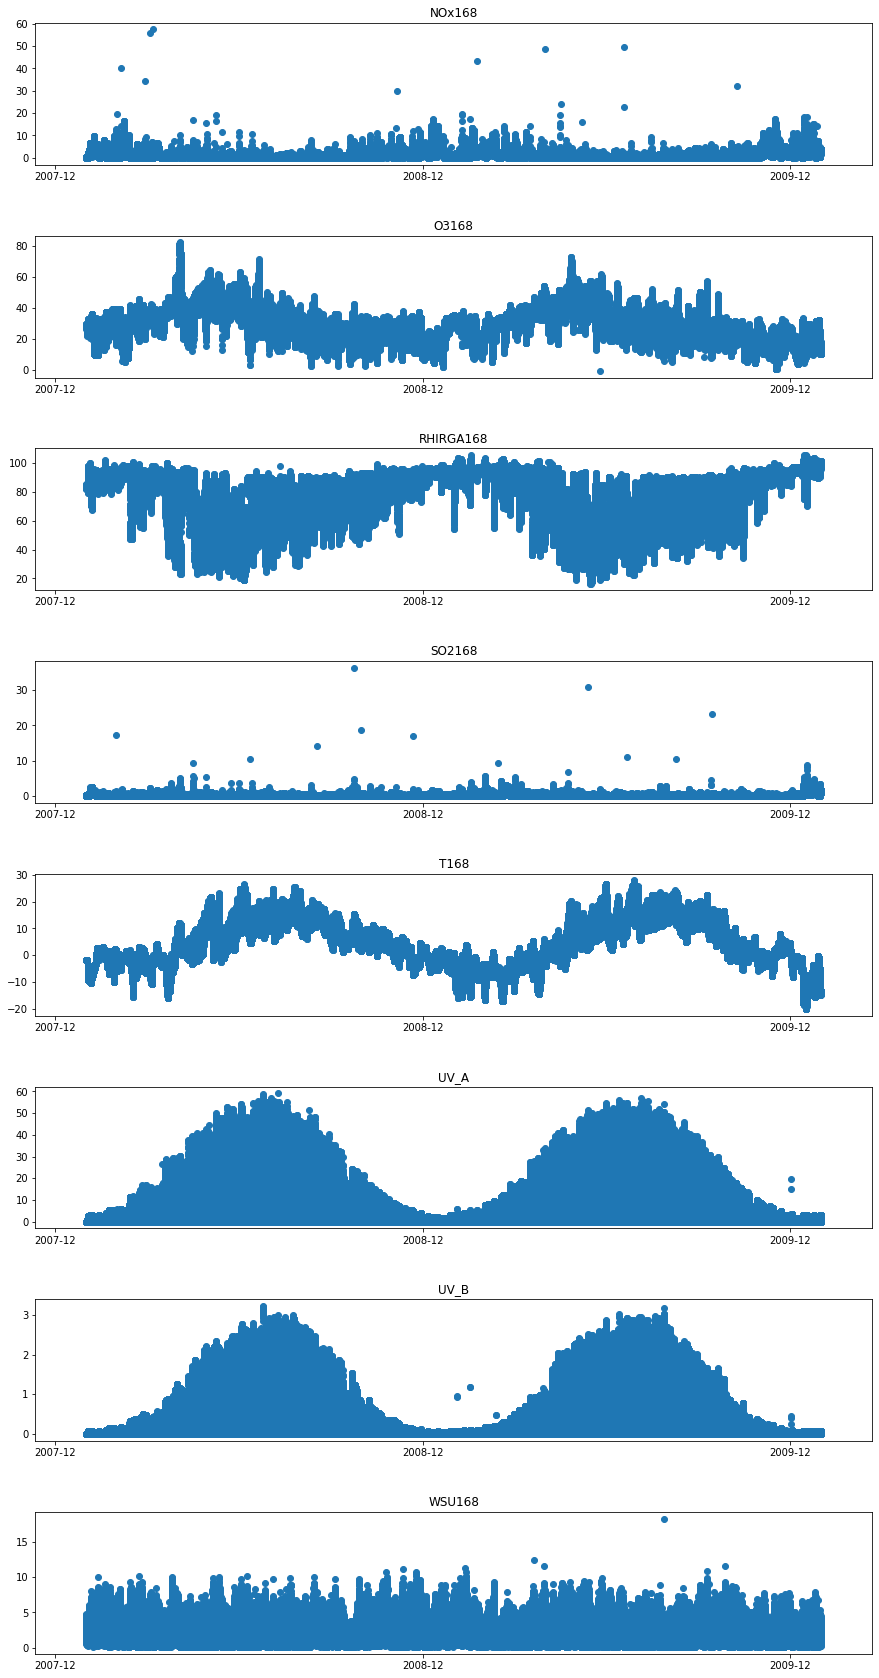

In [55]:
fig, axe = plt.subplots(df_raw.shape[1] - 1,1, figsize = (15, 30))
axe = axe.flatten()
for i in range(1, df_raw.shape[1]):
    axe[i-1].scatter(df_raw.Time, df_raw.iloc[:,i])
    axe[i-1].set_title(df_raw.columns[i])
    axe[i-1].xaxis.set_major_locator(matplotlib.dates.MonthLocator(bymonth=12, bymonthday=1, interval=1, tz=None))
    
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)

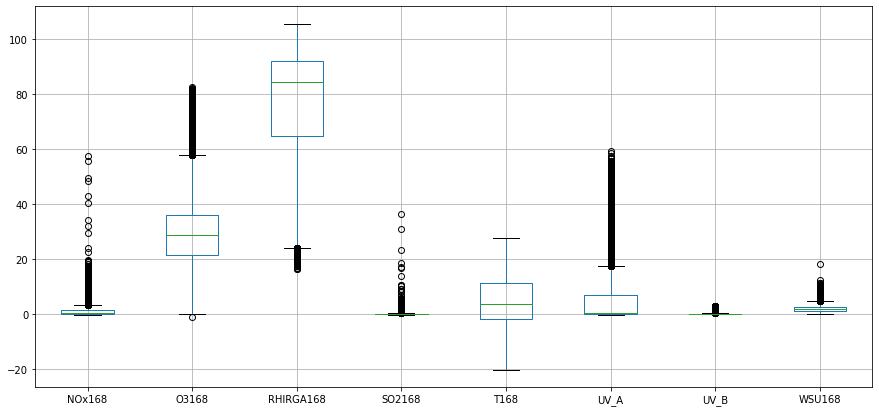

In [56]:
df_raw.boxplot(figsize = (15, 7))

<div class="alert alert-block alert-info">
    
Detecting outlier using boxplot for the raw time-series of two years is controversal because:
    
- Time-series are usually not stationary
    
- If the values only peak during a short time of every year (for example during the last week of every winter), then only a small set of data have such a high values (because there are 53 weeks in a year). As a result, the boxplot will consider those as outlier.
    
Instead, detecting outlier based on the distribution of the differences between two consecutive observations is a better idea. We wil make a function to remove outlier by first compute the distribution of diffences between two consecutive values. Then those differences that have $ \left | Z-score  \right |$ larger than 9 will be considered as outlier. In simple words, the increase between consecutive values will be removed (put as NaN) if they are too large in their distribution.

In [57]:
# Remove outlier based on quantile
#def remove_outlier_quantile(dataframe, quantile = 0.95, timecolumn = 'Time'):
#    data = dataframe.copy(deep = True)
#    for col in data:
#        if col not in [timecolumn]:
#            column_nona = data.loc[~data[col].isna(), col]
#            delta = column_nona - column_nona.shift(1)
#            q = delta.quantile(quantile)
#            idx = delta[delta > q].index
#            data.loc[idx, col] = np.NaN
#    return data

In [58]:
# Remove outlier based on zscore
def remove_outlier(dataframe, zscore = 1.96, timecolumn = 'Time'):
    from scipy import stats
    data = dataframe.copy(deep = True)
    for col in data:
        if col not in [timecolumn]:
            column_nona = data.loc[~data[col].isna(), col]
            delta = column_nona - column_nona.shift(1)
            delta.iloc[0] = np.nanmean(delta) # To include first value of the time series
            abs_zscore = np.abs(stats.zscore(delta))
            idx = delta[abs_zscore > zscore].index
            data.loc[idx, col] = np.NaN
    return data

#### Remove outliers for parameters + condense data and check the plot on new data

In [59]:
df_processed = remove_outlier(df_raw, zscore = 2)

condense_processed = remove_outlier(condense_raw)

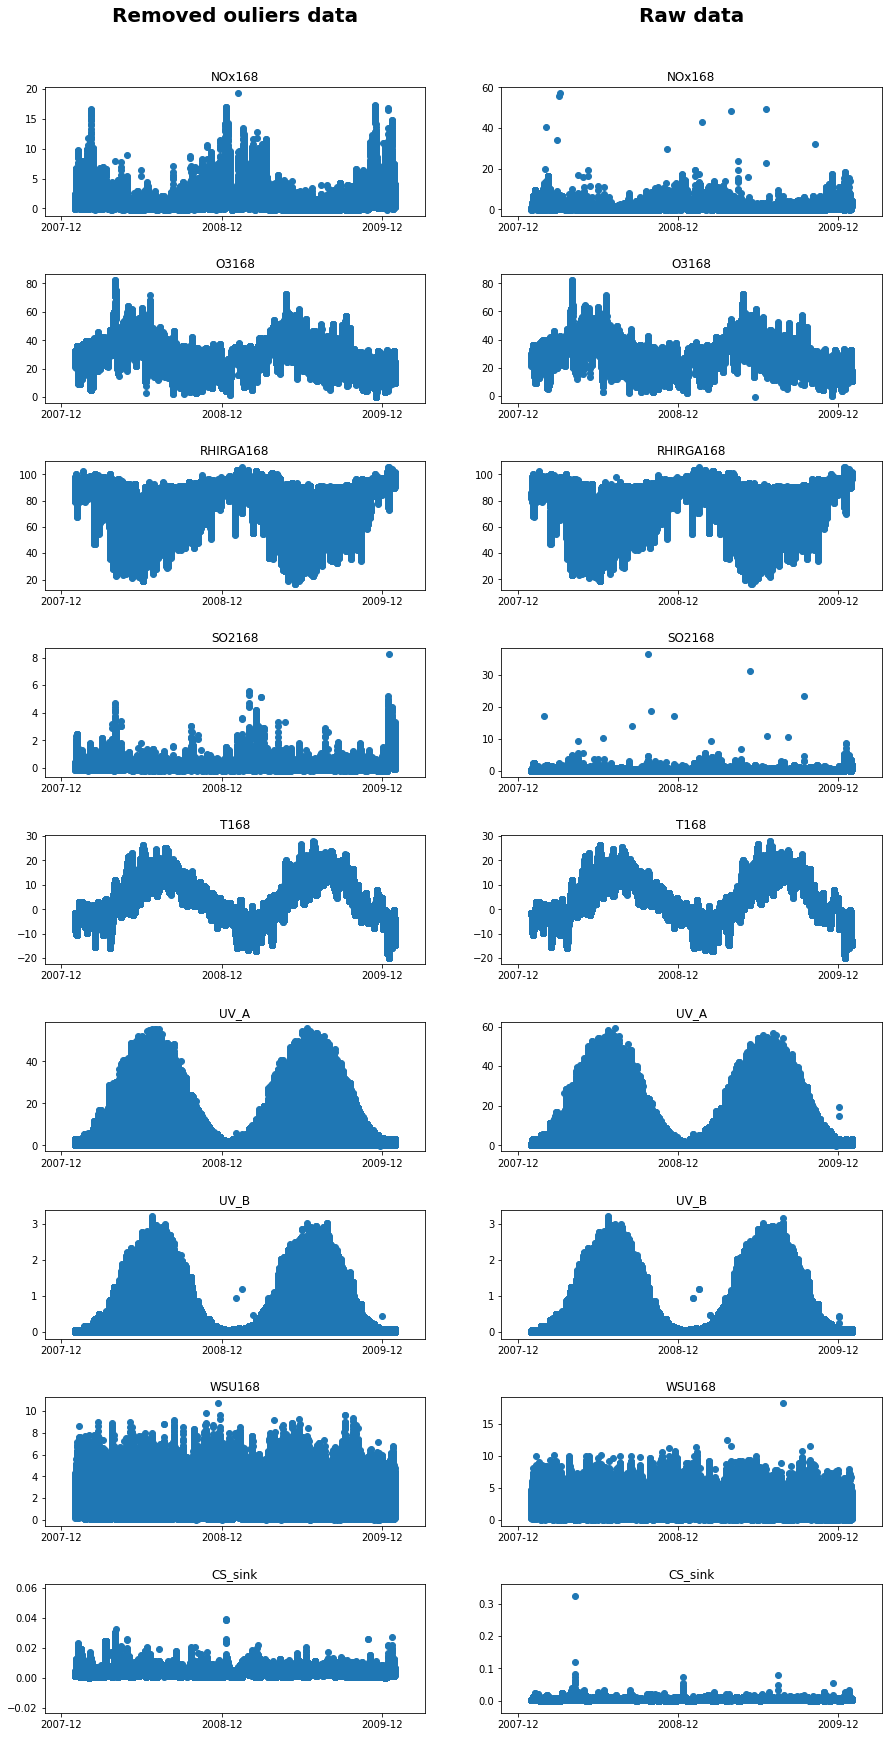

In [60]:
fig, axe = plt.subplots(df_raw.shape[1] + 1,2, figsize = (15, 30), gridspec_kw={"height_ratios":np.append(0.005, np.repeat(1,df_raw.shape[1]))})

axe[0,0].axis('off')
axe[0,0].set_title('Removed ouliers data', fontweight='bold', fontsize = 20)
axe[0,1].axis('off')
axe[0,1].set_title('Raw data', fontweight='bold', fontsize = 20)

for i in range(1, df_raw.shape[1]):
    axe[i, 0].scatter(df_processed.Time, df_processed.iloc[:,i])
    axe[i, 0].set_title(df_processed.columns[i])
    axe[i, 0].xaxis.set_major_locator(matplotlib.dates.MonthLocator(bymonth=12, bymonthday=1, interval=1, tz=None))
    axe[i, 1].scatter(df_raw.Time, df_raw.iloc[:,i])
    axe[i, 1].set_title(df_raw.columns[i])
    axe[i, 1].xaxis.set_major_locator(matplotlib.dates.MonthLocator(bymonth=12, bymonthday=1, interval=1, tz=None))    

axe[df_raw.shape[1] , 0].scatter(condense_processed.Time, condense_processed.CS_sink)
axe[df_raw.shape[1] , 0].set_title('CS_sink')
axe[df_raw.shape[1] , 0].xaxis.set_major_locator(matplotlib.dates.MonthLocator(bymonth=12, bymonthday=1, interval=1, tz=None))
axe[df_raw.shape[1] , 1].scatter(condense_raw.Time, condense_raw.CS_sink)
axe[df_raw.shape[1] , 1].set_title('CS_sink')
axe[df_raw.shape[1] , 1].xaxis.set_major_locator(matplotlib.dates.MonthLocator(bymonth=12, bymonthday=1, interval=1, tz=None)) 

fig.subplots_adjust(left=None, bottom=0.1, right=None, top=None, wspace=None, hspace=0.5)

#### Calculate hourly data

In [61]:
condense_hourly = condense_processed.groupby([condense_processed["Time"].dt.date,condense_processed["Time"].dt.hour]).mean()
df_hourly = df_processed.groupby([df_processed["Time"].dt.date,df_processed["Time"].dt.hour]).mean()
combined_hourly = condense_hourly.join(df_hourly)
combined_hourly.index.rename(['Date', 'Hour'], inplace = True)

### Event data
#### Let's drop Type Apple, Type Bump, Type Rain and Type Featureless due to no data

In [62]:
event.drop(['Type Apple', 'Type Rain', 'Type Bump', 'Type Featureless'], axis = 1, inplace = True)

#### New variabable that combines all events and then remove all those event it replaces

In [63]:
event['Event'] = event['Type Ia'] + event['Type Ib'] + event['Type II']
event.drop(['Type Ia', 'Type Ib', 'Type II'], axis = 1, inplace = True)

#### Calculate daily data

In [64]:
condense_daily = condense_processed.groupby([condense_processed["Time"].dt.date]).mean()
df_daily = df_processed.groupby([df_processed["Time"].dt.date]).mean()

combined_daily = event[["Event", "Nonevent", "Time"]].set_index('Time').join(condense_daily).join(df_daily)

#### Add proxy 

$[H_2SO_4]_{proxy} = k \cdot \frac{[SO_2][UVB]}{CS}$

In [65]:
combined_daily['proxy'] = combined_daily['SO2168'] * combined_daily['UV_B'] * 9.9e-7 / combined_daily['CS_sink'] * 2.62e-6 / 64 * 6.023e23 / 1e6

Event daily

In [66]:
condition = [combined_daily.Event == 1, combined_daily.Nonevent == 1]
choice = ['Event', 'Nonevent']
combined_daily['Event_category'] = np.select(condition, choice, default = 'Undefined')
combined_daily.drop(['Event', 'Nonevent'], axis = 1, inplace = True)

# Analysis

## Preliminary analysis

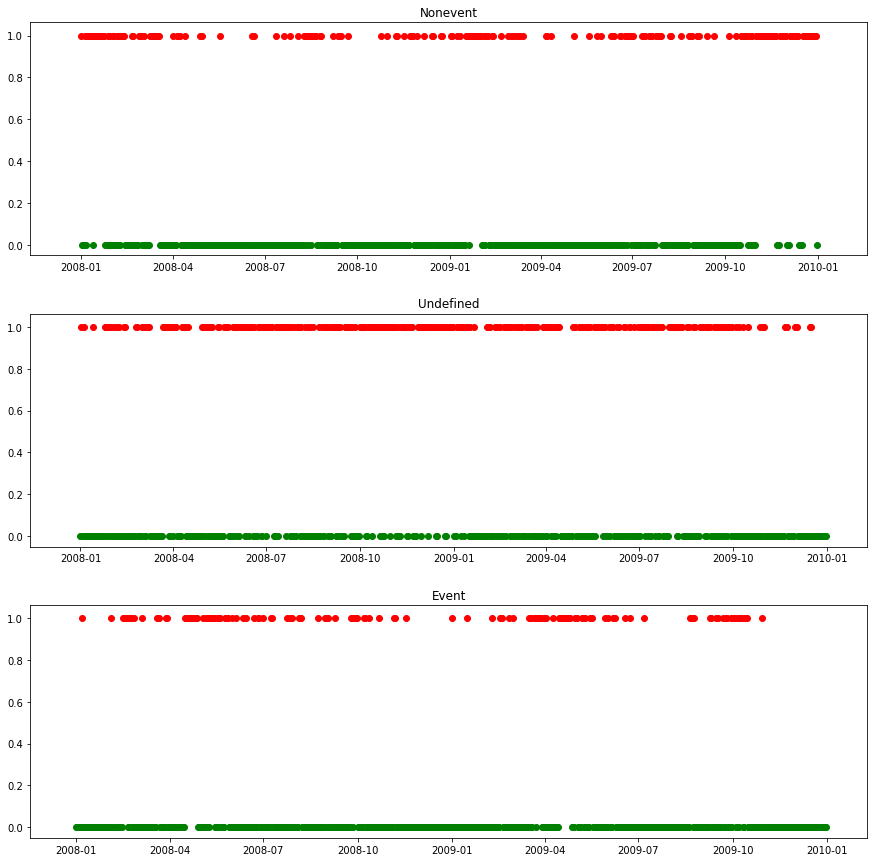

In [67]:
fig, ax = plt.subplots(event.shape[1]-1, figsize = (15, 15))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.25)
for i, value in enumerate([col for col in event.columns if col != 'Time']):
    ax[i].scatter(event[event[value] ==1]["Time"], event[event[value] ==1][value], c = "r")
    ax[i].scatter(event[event[value] ==0]["Time"], event[event[value] ==0][value], c = "green")
    ax[i].set_title(value)

## Correlation

## Plot

### Correlation plot
Choose color color bar first

In [68]:
cmap = sns.choose_diverging_palette(as_cmap = True)

interactive(children=(IntSlider(value=220, description='h_neg', max=359), IntSlider(value=10, description='h_p…

Change the color bar above then run the code below again to apply new color bar (Don't run the code above again)

Text(0.5, 1, 'Hourly correlation')

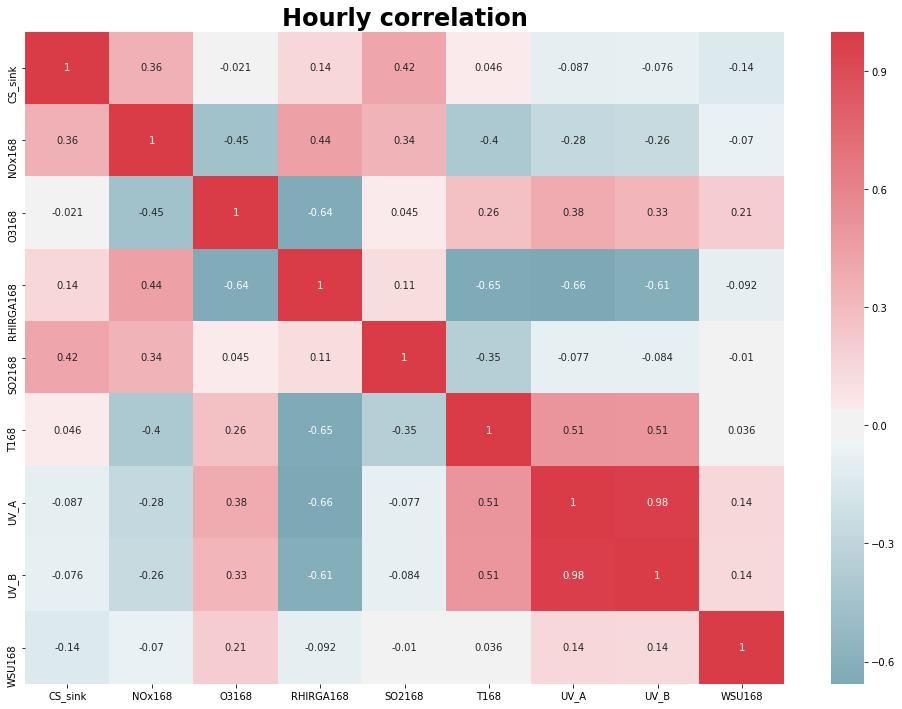

In [69]:
fig, ax = plt.subplots(figsize = (17,12))
sns.heatmap(combined_hourly.corr(), cmap = cmap, center=0.00, ax = ax, annot = True)
ax.set_ylim(combined_hourly.shape[1],0)
ax.set_title('Hourly correlation', weight = "bold", fontsize=24)

Text(0.5, 1, 'Daily correlation on Non-Event day')

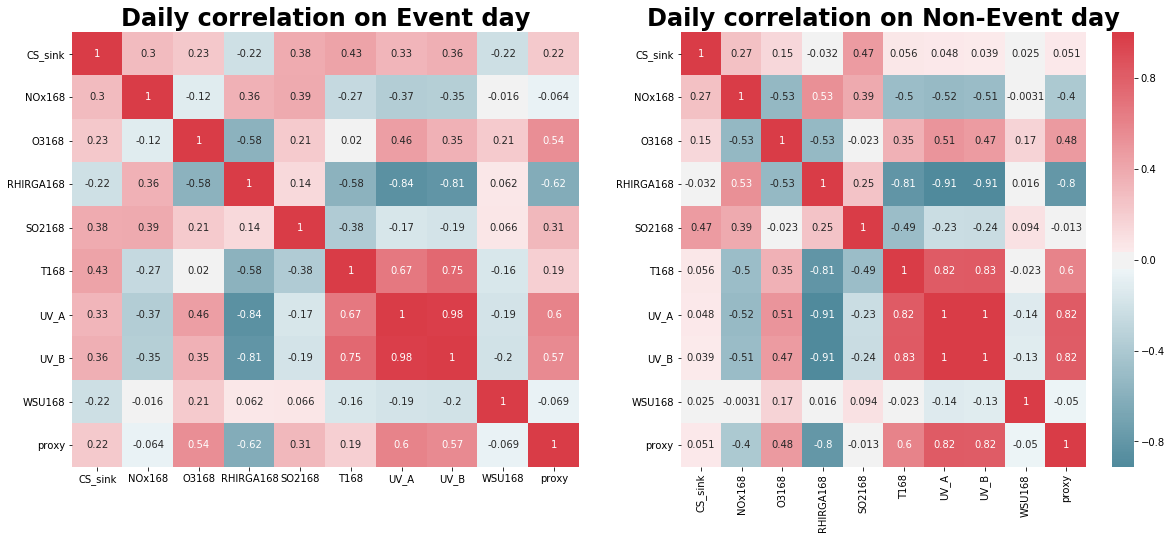

In [70]:
fig, ax = plt.subplots(1, 2, figsize = (20,8))
sns.heatmap(combined_daily[combined_daily.Event_category == 'Event'].iloc[:,:-1].corr(), cmap = cmap, center=0.00, ax = ax[0], annot = True, cbar = False)
ax[0].set_ylim(combined_daily.shape[1]-1,0)
ax[0].set_title('Daily correlation on Event day', weight = "bold", fontsize=24)
sns.heatmap(combined_daily[combined_daily.Event_category == 'Nonevent'].iloc[:,:-1].corr(), cmap = cmap, center=0.00, ax = ax[1], annot = True, cbar = True)
ax[1].set_ylim(combined_daily.shape[1]-1,0)
ax[1].set_title('Daily correlation on Non-Event day', weight = "bold", fontsize=24)

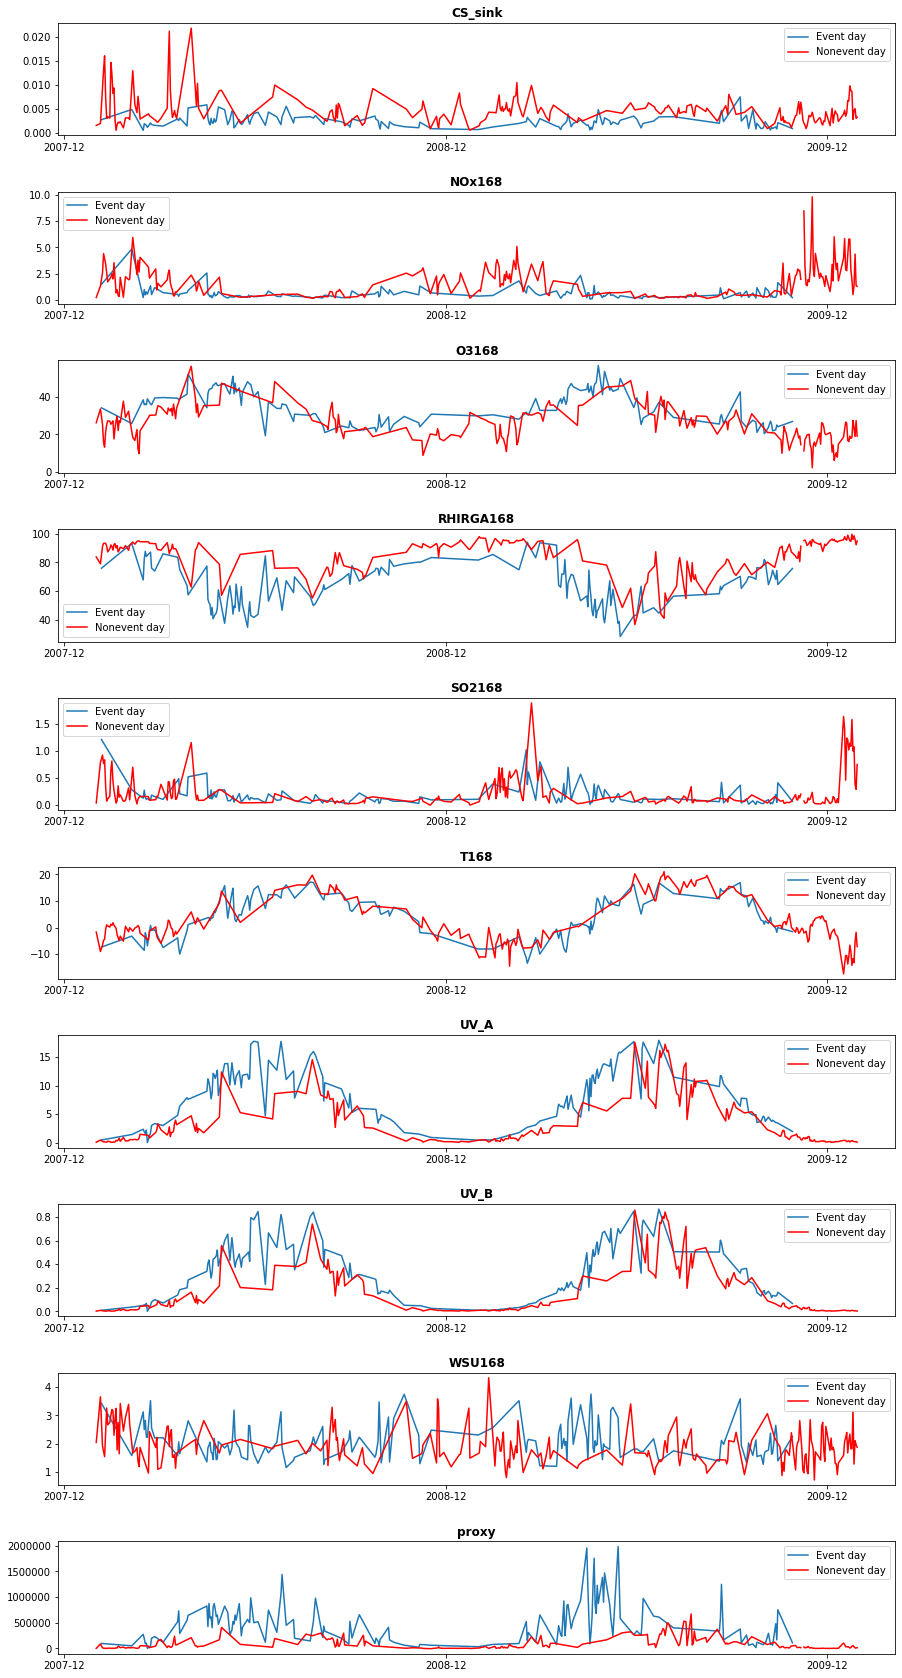

In [71]:
fig, axe = plt.subplots(combined_daily.shape[1]-1, figsize = (15, 30))
for i in range(combined_daily.shape[1]-1):
    axe[i].plot(combined_daily[combined_daily.Event_category == 'Event'].iloc[:,i], label = 'Event day')
    axe[i].plot(combined_daily[combined_daily.Event_category == 'Nonevent'].iloc[:,i], c = 'red', label = 'Nonevent day')
    axe[i].set_title(combined_daily.columns[i], fontweight = 'bold')
    axe[i].xaxis.set_major_locator(matplotlib.dates.MonthLocator(bymonth=12, bymonthday=1, interval=1, tz=None))
    axe[i].legend()
    
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)

## Monthly box plot for each variable based on event

#### Monthly

In [72]:
combined_daily

,CS_sink,NOx168,O3168,RHIRGA168,SO2168,T168,UV_A,UV_B,WSU168,proxy,Event_category
Time,,,,,,,,,,,
2008-01-01,0.001562,0.240984,26.186721,83.887018,0.031639,-1.691005,0.114325,0.002070,2.043178,1023.165603,Nonevent
2008-01-02,0.001884,0.986090,27.953806,89.362119,0.120449,-6.271936,0.375949,0.007539,1.866887,11768.382664,Undefined
2008-01-03,0.004332,1.917375,28.203667,91.073723,0.228625,-7.422174,0.295983,0.006157,2.579880,7931.196339,Undefined
2008-01-04,0.008393,3.787660,24.216099,96.456423,1.096071,-9.454689,0.463749,0.008695,2.582531,27717.835963,Undefined
2008-01-05,0.001965,1.320064,33.458590,79.021200,0.781210,-8.987906,0.493587,0.008994,3.658363,87298.299455,Nonevent
...,...,...,...,...,...,...,...,...,...,...,...
2009-12-27,0.004697,1.345588,23.605756,98.584105,1.071208,-13.211509,0.244837,0.005497,1.272488,30601.018653,Nonevent
2009-12-28,0.005042,4.360378,18.859454,96.166348,0.373640,-5.267707,0.204049,0.004322,2.101240,7818.640548,Nonevent
2009-12-29,0.003047,1.354790,27.278326,92.307261,0.283625,-1.790049,0.214302,0.004643,1.958635,10549.839294,Nonevent


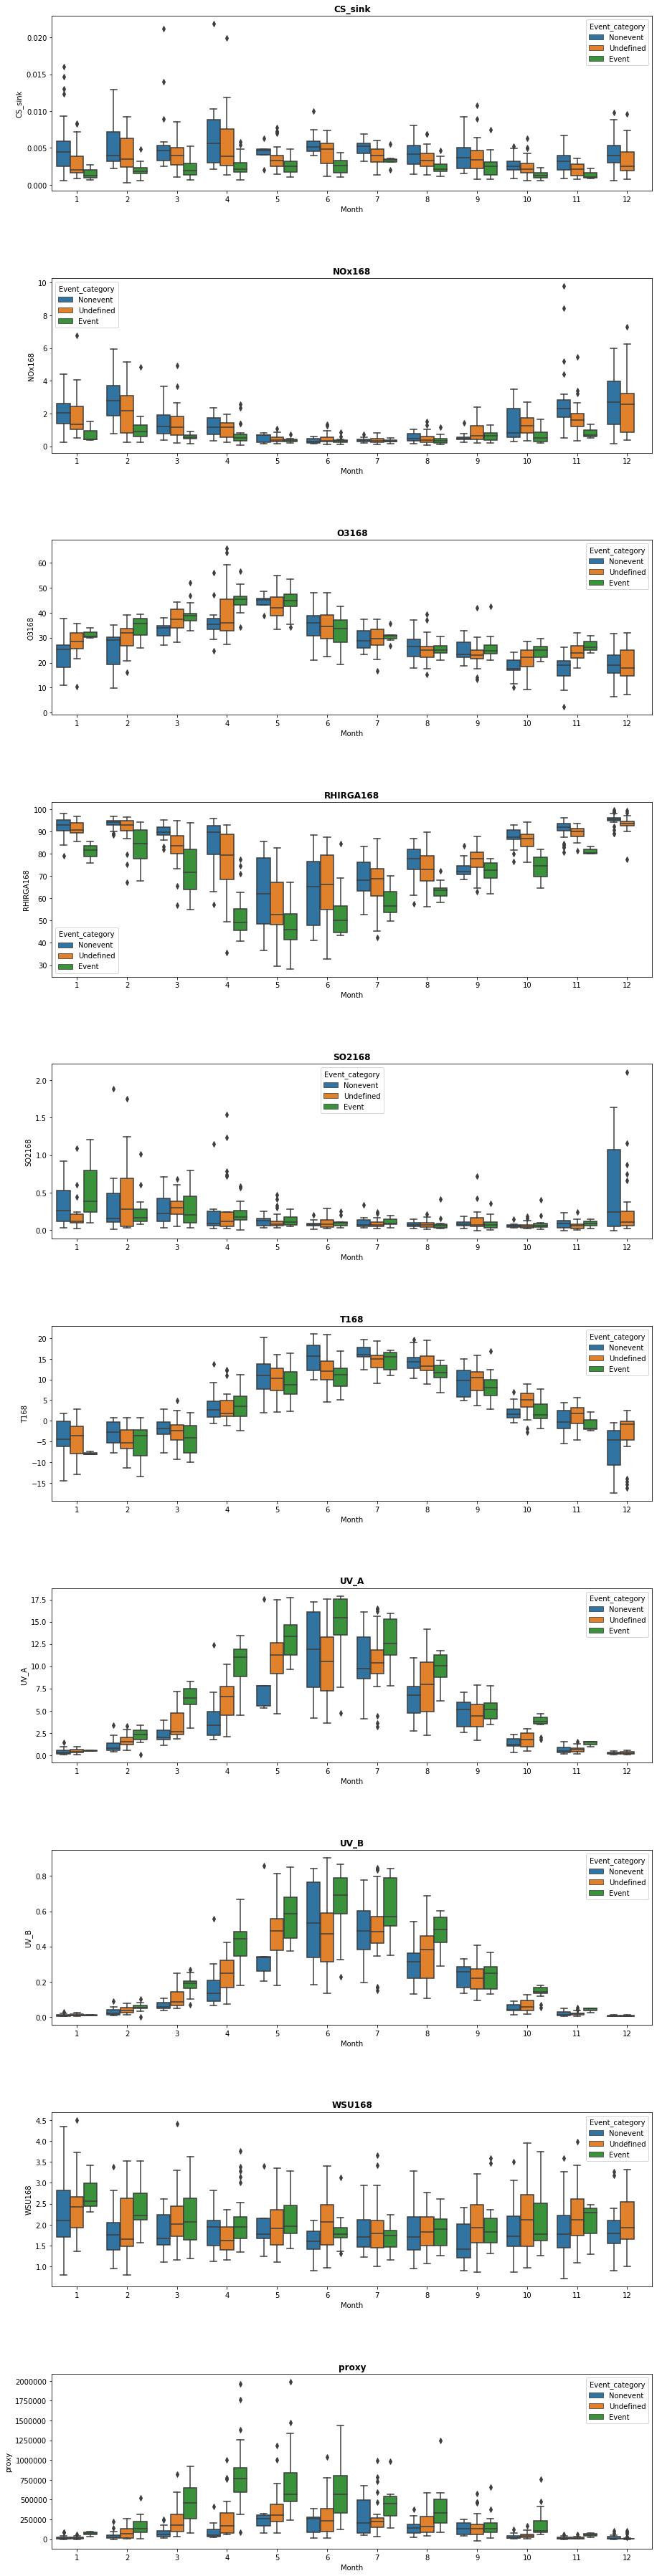

In [73]:
fig, ax = plt.subplots(10, figsize = (15, 65))
for i in range(10):
    sns.boxplot(x = combined_daily.index.month, y = combined_daily.iloc[:,i], hue = combined_daily.iloc[:,-1], ax = ax[i])
    ax[i].set_title(combined_daily.columns[i], fontweight = 'bold')
    ax[i].set_xlabel('Month')    
    
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)